**Индексирование**

Индекс можно строить в базе данных (лучше использовать БД sqlite)

Схема простого индекса состоит из четырёх таблиц. Первая (urllist) – это список проиндексированных URL. Вторая (wordlist) – список слов, а третья (wordlocation) – список мест вхождения слов в документы. Место вхождения – это номер слова в документе. В таблице link хранятся идентификаторы двух URL, связанных ссылкой.

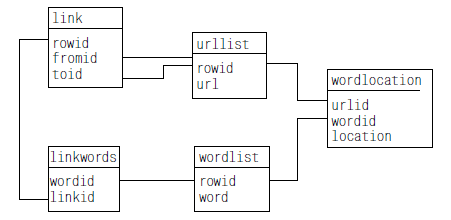

Ссылка на дамп бд. 

https://drive.google.com/file/d/1HR3i7VuCx_HlcX1c2L0bUgTfqkAZ43NC/view?usp=sharing

In [ ]:
import sqlite3

con = sqlite3.connect('searchengine.db')
f = open('dump.sql','r')
sql = f.read()
cur = con.cursor()
cur.executescript(sql)

# Итоговое задание 1

Напишите функцию crawler, которая заходит на ресурс и собирает с него ссылки с помощью функции extract_links_from_html. Затем функция проходит по всем извлеченным ссылкам (url'ам) и собирает ссылки с этих документов. Все url'ы записываются в таблицу urllist. В таблицу link записываются пары идентификаторов из таблицу urllist, означающие откуда и куда ведёт ссылка.

Примените crawler не менее чем к трём разным ресурсам примерно одинаковой тематики.

В таблице link должно быть не менее 1000 записей.

In [ ]:
import sqlite3
con=sqlite3.connect('searchindex.db')

In [ ]:
def createindextables():
  con.execute('create table urllist(url unique)')
  con.execute('create table wordlist(word unique)')
  con.execute('create table wordlocation(urlid,wordid,location)')
  con.execute('create table link(fromid integer,toid integer unique)')
  con.execute('create index wordidx on wordlist(word)')
  con.execute('create index urlidx on urllist(url)')
  con.execute('create index wordurlidx on wordlocation(wordid)')
  con.execute('create index urltoidx on link(toid)')
  con.execute('create index urlfromidx on link(fromid)')
  con.commit()

In [ ]:
createindextables()

In [ ]:
#скачиваем интернет

from urllib.request import urlopen
def download_from_the_internet(url):
    try:
        return urlopen(url).read().decode('utf-8')
    except KeyboardInterrupt:
        raise
    except:
        return None

In [ ]:
#извлекаем ссылки

from bs4 import BeautifulSoup
from urllib.parse import urljoin

def extract_links_from_html(url, html):
    parser = BeautifulSoup(html)
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]

In [ ]:
#возвращаем идентификатор записи

def getentryid(table,field,value):
  cur=con.execute("select rowid from %s where %s='%s'" % (table,field,value))
  res=cur.fetchone( )
  if res==None:
    cur=con.execute("insert into %s (%s) values ('%s')" % (table,field,value))
    return cur.lastrowid
  else:
    return res[0]

In [ ]:
#добавляем записи в таблицу link

def addlinkref(urlFrom,urlTo):
  fromid=getentryid('urllist','url',urlFrom)
  toid=getentryid('urllist','url',urlTo)
  if fromid==toid: return
  cur=con.execute("insert or ignore into link(fromid,toid) values (%d,%d)" % (fromid,toid))

In [ ]:
#Все url'ы записываются в таблицу urllist 

def addurllist(url):
  cur = con.execute("INSERT OR IGNORE into urllist(url) values ('%s')" % (url))

In [ ]:
def crawler(url):

    html = download_from_the_internet(url)
    links = extract_links_from_html(url, html)

    for link in links:
        try:
            html = download_from_the_internet(link)
            urls = extract_links_from_html(link, html)

            for url in urls:
                addurllist(url)
                addlinkref(link, url)
        except TypeError: 
          continue

In [ ]:
crawler('https://yogajournal.ru/')

In [ ]:
crawler('https://samadhy.ru/')

In [ ]:
#Посчитаем количество записей в таблице link 

with con:    
    cur = con.cursor()    
    cur.execute('SELECT COUNT(*) from link')
    cur_result = cur.fetchone()
print(cur_result)

(2558,)


In [ ]:
#И проверим, что туда записаны идентификаторы 
with con:    
    cur = con.cursor()    
    cur.execute('SELECT * from link')
    rows = cur.fetchall()
print(rows[:10])

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11)]


# Итоговое задание 2

Протестируйте функции gettextonly и separatewords. При необходимости доработайте. Результат функции separatewords нужно записать в таблицу wordlist.

In [ ]:
import re
import pprint 
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
#Оставляем только русский язык, потому что в текстах нашей тематики нет английских названий и заимствований

#Добавляем букву ё

def gettextonly(html):
  text = BeautifulSoup(html).get_text()
  text = re.sub("[^а-яА-ЯёЁ]"," ", text) 
  return text

In [ ]:
!pip install pymorphy2

from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()


     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 8.2MB 6.5MB/s 


In [ ]:
#протестируем

def separatewords(text):
  words = text.lower().split()
  wordsnormalized = []
  for w in words:
        lemma = pymorphy2_analyzer.parse(w)
        wordsnormalized.append(lemma[0].normal_form)
  return wordsnormalized

In [ ]:
url = 'https://yogacenter.ru/'
html = download_from_the_internet(url)

In [ ]:
pp.pprint(separatewords(gettextonly(html)))

[   'йог',
    'центр',
    'москва',
    'начинающий',
    'курс',
    'занятие',
    'йога',
    'центр',
    'просветление',
    'контакт',
    'культурный',
    'центреэтный',
    'магазинфито',
    'кафефотогалереяконтактытеория',
    'йогийог',
    'сообщество',
    'новослободский',
    'долгоруковский',
    'аэропорт',
    'черняховский',
    'дом',
    'корпус',
    'часы',
    'работа',
    'новость',
    'теория',
    'галереяконтакт',
    'компаниирасписание',
    'ценыэтный',
    'магазинфито',
    'кафе',
    'новый',
    'группа',
    'хатх',
    'йога',
    'выходной',
    'кундалини',
    'йог',
    'цигун',
    'новый',
    'группа',
    'утренний',
    'группа',
    'йога',
    'зал',
    'аэропорт',
    'йог',
    'центр',
    'москва',
    'сегодня',
    'йог',
    'это',
    'модно',
    'йога',
    'заниматься',
    'весь',
    'мир',
    'включая',
    'знаменитость',
    'однако',
    'цель',
    'разный',
    'один',
    'это',
    'разновидность',
    'фитнес

In [ ]:
#В индекс не будем включать однобуквенные слова и стоп-слова.

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # стоп-слова из NLTK

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
ignorewords = stopwords.words('russian')

In [ ]:
#Сохраняем  в таблицу wordlist

def separatewords(text):
  words = text.lower().split()
  wordsnormalized = []
  for w in words:
    if len(w) > 1 and w not in ignorewords:
        lemma = pymorphy2_analyzer.parse(w)
        cur = con.execute("insert or ignore into wordlist(word) values ('%s')" % (lemma[0].normal_form))
        wordsnormalized.append(lemma[0].normal_form)
  return wordsnormalized

# Итоговое задание 3

Пока мы проиндексировали только одну страницу. Доработайте написанную ранее функцию crawler, дополнив её написанными ранее функции для построения индекса. Не забывайте, что в индекс не нужно включать однобуквенные слова и стоп-слова.

In [ ]:
def isindexed(url):
    u=con.execute ("select rowid from urllist where url='%s'" % url).fetchone()
    if u!=None:
      v= con.execute('select * from wordlocation where urlid=%d' % u[0]).fetchone()
      if v!=None: return True
    return False

def addtoindex(url):
  if isindexed(url): return
  print ('Индексируется %s' % url)
  
  html = download_from_the_internet(url)

  # Получить список слов
  words = separatewords (gettextonly(html))

  # Получить идентификатор URL
  urlid = getentryid('urllist','url',url)

  # Связать каждое слово с этим URL
  for i in range(len(words)):
    word=words[i]
    wordid = getentryid('wordlist', 'word', word)
    con.execute("insert into wordlocation(urlid,wordid,location) values (%d,%d,%d)" % (urlid,wordid,i))

In [ ]:
addtoindex('https://yogacenter.ru/')

Индексируется https://yogacenter.ru/


In [ ]:
getentryid('wordlist', 'word', 'йога')

7

In [ ]:
cur=con.execute("select rowid from %s where %s='%s'" % ('wordlist','word', 'йога'))
res=cur.fetchone( )

In [ ]:
print (res)

(7,)


Поигрались с проверкой функций, теперь допишем паука.

In [ ]:
def crawler(url):

    html = download_from_the_internet(url)
    links = extract_links_from_html(url, html)

    for link in links:
        try:
            html = download_from_the_internet(link)
            urls = extract_links_from_html(link, html)

            for url in urls:
                addurllist(url)
                addlinkref(link, url)
                addtoindex(url)
        except TypeError: 
          continue

Воспользуемся пауком заново, перезаписав БД.

In [ ]:
crawler('https://yogacenter.ru/')

Индексируется https://yogacenter.ru/index.php?option=com_content&view=article&id=68&Itemid=80
Индексируется https://yogacenter.ru/shop.php
Индексируется https://yogacenter.ru/page.php?id=5
Индексируется https://yogacenter.ru/#maingallery
Индексируется https://yogacenter.ru/#bot-contact
Индексируется https://yogacenter.ru/#teorija
Индексируется https://yogacenter.ru/#community
Индексируется https://yogacenter.ru/kontaktnaya-informatciya
Индексируется https://yogacenter.ru/
Индексируется https://yogacenter.ru/o-kulturnom-tsentre
Индексируется https://yogacenter.ru/raspisanie-zanjatij
Индексируется https://yogacenter.ru/ezotericheskij-magazin
Индексируется https://yogacenter.ru/fito-kafe
Индексируется http://indiashop.ru/
Индексируется https://yogacenter.ru/#teorija 
Индексируется https://yogacenter.ru/fotogalereya
Индексируется https://yogacenter.ru/yoga-for-beginners
Индексируется mailto:yogacenter@mail.ru
Индексируется https://indiashop.ru/
Индексируется https://yogacenter.ru/ezoterich

In [ ]:
crawler('https://yogajournal.ru/')

Индексируется https://yogajournal.ru/bitrix/rk.php?id=65&site_id=s1&event1=banner&event2=click&event3=1+%2F+%5B65%5D+%5Bbig_top%5D+%D0%9D%D0%B0%D1%88+%D0%B1%D0%B0%D0%BD%D0%BD%D0%B5%D1%80+940%D1%85180+%28107+%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%29&goto=https%3A%2F%2Fyogajournal.ru%2Flp%2Fmantra-marafon-2020%2F#speak
Индексируется https://yogajournal.ru/bitrix/rk.php?id=65&site_id=s1&event1=banner&event2=click&event3=1+%2F+%5B65%5D+%5Bbig_top%5D+%D0%9D%D0%B0%D1%88+%D0%B1%D0%B0%D0%BD%D0%BD%D0%B5%D1%80+940%D1%85180+%28107+%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%29&goto=https%3A%2F%2Fyogajournal.ru%2Flp%2Fmantra-marafon-2020%2F#prog
Индексируется https://yogajournal.ru/bitrix/rk.php?id=65&site_id=s1&event1=banner&event2=click&event3=1+%2F+%5B65%5D+%5Bbig_top%5D+%D0%9D%D0%B0%D1%88+%D0%B1%D0%B0%D0%BD%D0%BD%D0%B5%D1%80+940%D1%85180+%28107+%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%29&goto=https%3A%2F%2Fyogajournal.ru%2Flp%2Fmantra-marafon-2020%2F#rez
Индексируется https://yogajournal.ru/bitrix/rk.php?id=65&site_id=s1&ev

In [ ]:
crawler('https://samadhy.ru/')

Индексируется https://samadhy.ru/
Индексируется https://samadhy.ru/shkola-iogi/o-shkole-iogi.html
Индексируется https://samadhy.ru/opredelenie-iogi.html
Индексируется https://samadhy.ru/praktika-iogi/iama-niiama.html
Индексируется https://samadhy.ru/ioga-i-religiia/uchenie-o-dao-i-korreliatcii-s-iogicheskimi-praktikami.html
Индексируется https://samadhy.ru/effekty-asan-i-pranaiam.html
Индексируется https://samadhy.ru/pervoistochniki-po-ioge.html
Индексируется https://samadhy.ru/kontakty.html
Индексируется https://samadhy.ru/shkola-iogi/ioga-dlia-nachinaiushchikh-nabor-v-novuiu-gruppu.html
Индексируется https://samadhy.ru/otzyvy/ivan-m-26-let-zanimaetsia-v-shkole-2-5-goda.html
Индексируется https://samadhy.ru/otzyvy/irina-a-39-let-zanimaetsia-v-shkole-3-goda.html
Индексируется https://samadhy.ru/otzyvy.html
Индексируется https://www.yoga-store.ru/category/yogamats/
Индексируется https://www.ayurveda-shop.ru/category/chavanprash/
Индексируется https://samadhy.ru/shkola-iogi/ioga-dlia-ber

**Поисковые запросы**

Теперь у нас есть работающий паук и большой набор проиндексированных документов, и мы готовы приступить к реализации той части поисковой машины, которая выполняет поиск.

Таблица wordlocation обеспечивает простой способ связать слова с документами, так что мы можем легко найти, какие страницы содержат данное слово. 

# Итоговое задание 4

Доработайте getmatchrows так, чтобы обрабатывалась ситуация, когда вводится слова, которых нет в индексе.

Попробуйте доработать так, что учитывались не только слова запроса, но и "похожие" на них слова. Для этого можно взять модель с rusvectores. Желательно эту модель дообучить.

In [ ]:
#функция, которая принимает строку запроса, разбивает ее на слова и строит SQL-запрос 
#для поиска URL тех документов, в которые входят все указанные слова.

def getmatchrows1(q):
    # заведём строки для дальнейшего формирования запроса
    fieldlist='w0.urlid'
    tablelist=''
    clauselist=''

    wordids=[]

    # разобъём запрос на отдельные слова
    words=separatewords(q)
    tablenumber=0

    for word in words:
      # получим ID слова из запроса
      wordrow=con.execute("select rowid from wordlist where word='%s'" % word).fetchone()
      if wordrow!=None:
        wordid=wordrow[0]
        wordids.append(wordid)

        if tablenumber >0: # это для случаев, когда в запросе более одного слова
          tablelist+=','
          clauselist+=' and '
          clauselist+='w%d.urlid=w%d.urlid and ' % (tablenumber-1,tablenumber)
          
        fieldlist+=',w%d.location' % tablenumber
        tablelist+='wordlocation w%d' % tablenumber
        clauselist+='w%d.wordid=%d' % (tablenumber,wordid)
        tablenumber+=1

    # сформировать запрос в базу
    fullquery='select %s from %s where %s' % (fieldlist,tablelist,clauselist)
    cur=con.execute(fullquery)
    rows=[row for row in cur]

    return rows,wordids

In [ ]:
getmatchrows1('обучение йоге')

([(4, 454, 6),
  (4, 454, 34),
  (4, 454, 43),
  (4, 454, 53),
  (4, 454, 79),
  (4, 454, 168),
  (4, 454, 180),
  (4, 454, 182),
  (4, 454, 273),
  (4, 454, 312),
  (4, 454, 316),
  (4, 454, 322),
  (4, 454, 425),
  (4, 454, 587),
  (4, 454, 613),
  (4, 454, 641),
  (4, 454, 653),
  (4, 496, 6),
  (4, 496, 34),
  (4, 496, 43),
  (4, 496, 53),
  (4, 496, 79),
  (4, 496, 168),
  (4, 496, 180),
  (4, 496, 182),
  (4, 496, 273),
  (4, 496, 312),
  (4, 496, 316),
  (4, 496, 322),
  (4, 496, 425),
  (4, 496, 587),
  (4, 496, 613),
  (4, 496, 641),
  (4, 496, 653),
  (5, 454, 6),
  (5, 454, 34),
  (5, 454, 43),
  (5, 454, 53),
  (5, 454, 79),
  (5, 454, 168),
  (5, 454, 180),
  (5, 454, 182),
  (5, 454, 273),
  (5, 454, 312),
  (5, 454, 316),
  (5, 454, 322),
  (5, 454, 425),
  (5, 454, 587),
  (5, 454, 613),
  (5, 454, 641),
  (5, 454, 653),
  (5, 496, 6),
  (5, 496, 34),
  (5, 496, 43),
  (5, 496, 53),
  (5, 496, 79),
  (5, 496, 168),
  (5, 496, 180),
  (5, 496, 182),
  (5, 496, 273),
  (5

In [ ]:
getmatchrows1('дзюдо')

([], [50329])

In [ ]:
import gensim # библиотека для загрузки и использвоания моделй w2v
from gensim.models import word2vec # непосредственно методы w2v
import urllib.request
from gensim.models import FastText

# Сравним две модели ruscorpora_mystem_cbow_300_2_2015 и ruscorpora_none_fasttextskipgram_300_2_2019

In [ ]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7f25420584a8>)

In [ ]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=59ada85559830e32b9420b3039688b944905e475b818d2fea17f6675ba0627f2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
!wget https://www.dropbox.com/s/y4wpgsqm0w3bnsn/model.model
!wget https://www.dropbox.com/s/jq86e8rw1fltg0z/model.model.vectors.npy
!wget https://www.dropbox.com/s/18zdnef65ah4oz9/model.model.vectors_ngrams.npy
!wget https://www.dropbox.com/s/68m65vlqunkbgqu/model.model.vectors_vocab.npy

--2020-11-26 10:02:35--  https://www.dropbox.com/s/y4wpgsqm0w3bnsn/model.model
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y4wpgsqm0w3bnsn/model.model [following]
--2020-11-26 10:02:35--  https://www.dropbox.com/s/raw/y4wpgsqm0w3bnsn/model.model
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee7459170a5e4b3a50820ac1a6.dl.dropboxusercontent.com/cd/0/inline/BD5ZkG61yghrW6Pv6Pctg8jaNvR_QT_7JMNrbuYS8rGrKafJghzi0NYPS0qRQTIvUtGfyrIG9hWh7xHc9e2zwen-9eW6_yTj7orWHjdW6WucwI6OMIwrvOzXGyF0zgo_GRo/file# [following]
--2020-11-26 10:02:35--  https://ucee7459170a5e4b3a50820ac1a6.dl.dropboxusercontent.com/cd/0/inline/BD5ZkG61yghrW6Pv6Pctg8jaNvR_QT_7JMNrbuYS8rGrKafJghzi0NYPS0qRQTIvUtGfyrIG9hWh7xHc9e2zwen-9eW6_yTj7orWHjdW6WucwI6OMI

In [ ]:
model_ru = gensim.models.KeyedVectors.load("model.model", mmap='r')

In [ ]:
model.most_similar(positive=['йога_S'], topn = 10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('йог_S', 0.61127108335495),
 ('бхотить_V', 0.5086572766304016),
 ('йогический_A', 0.4878861904144287),
 ('гимнастика_S', 0.46444010734558105),
 ('цигун_S', 0.40759971737861633),
 ('бободжанович_S', 0.39164337515830994),
 ('упражнение_S', 0.38716232776641846),
 ('дайвинг_S', 0.3844150900840759),
 ('гнана_S', 0.3832106590270996),
 ('медитация_S', 0.38057440519332886)]

In [ ]:
#в целом эта модель работает медленнее, чем ruscorpora_mystem_cbow_300_2_2015, однако и результаты здесь лучше

model_ru.most_similar(positive=['йога'], topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('йог', 0.7854173183441162),
 ('його', 0.6160902976989746),
 ('логопсихотерапия', 0.6127569675445557),
 ('дзюдо', 0.6033008098602295),
 ('психотерапия', 0.6015481352806091),
 ('дзэн', 0.6007423400878906),
 ('айкидо', 0.5951874852180481),
 ('каратэ', 0.5937231183052063),
 ('медитация', 0.5919702053070068),
 ('фитотерапия', 0.5882860422134399)]

In [ ]:
#если слова из запроса не оказалось, то учитываем синонимы
#напишем дополнительную функцию, которая будет искать айдишник слова, а если такого слова в списке нет - айдишник синонима

def getwordid(word):
    wordid = 0
    wordrow=con.execute("select rowid from wordlist where word='%s'" % word).fetchone()
    try:
        if wordrow != None:
            wordid = int(wordrow[0])
        elif wordrow == None:
            words = model_ru.most_similar(positive=[word], topn=10)
            while wordid == 0:
                    for i in range(len(words)):
                        wordrow = con.execute("select rowid from wordlist where word='%s'" % words[i][0]).fetchone()
                        if wordrow != None:
                            wordid = int(wordrow[0])
        if wordid != 0:
            return wordid 
    except AttributeError:
            pass

In [ ]:
#функция separatewords в предыдущем getmatchrows добавляла айдишники отсутствующих слов в wordlist
#перепишем ее 

def tokenize_query(q):
  words = q.lower().split()
  wordsnormalized = []
  for w in words:
    if len(w) > 1 and w not in ignorewords:
        lemma = pymorphy2_analyzer.parse(w)
        wordsnormalized.append(lemma[0].normal_form)
  return wordsnormalized

In [ ]:
def getmatchrows2(q):

    fieldlist='w0.urlid'
    tablelist=''
    clauselist=''

    wordids=[]
    
    words = tokenize_query(q)
    tablenumber=0

    for word in words:
        if getwordid(word) != None:
            wordid = getwordid(word)
            wordids.append(wordid)

            if tablenumber>0: # это для случаев, когда в запросе более одного слова
                tablelist+=','
                clauselist+=' and '
                clauselist+='w%d.urlid=w%d.urlid and ' % (tablenumber-1,tablenumber)
          
            fieldlist+=',w%d.location' % tablenumber
            tablelist+='wordlocation w%d' % tablenumber
            clauselist+='w%d.wordid=%d' % (tablenumber,wordid)
            tablenumber+=1

    fullquery='select %s from %s where %s' % (fieldlist,tablelist,clauselist)
    cur=con.execute(fullquery)
    rows=[row for row in cur]

    return rows,wordids

In [ ]:
getmatchrows1('дзюдо')

([], [50329])

In [ ]:
query = ("DELETE FROM wordlist WHERE word = 'дзюдо'")
con.execute(query)

In [ ]:
getmatchrows2('дзюдо')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([(1836, 230)], [19200])

In [ ]:
cur=con.execute("select word from %s where %s='%s'" % ('wordlist','rowid', 19200))
res=cur.fetchone( )
print(res)

('айкидо',)


In [ ]:
getmatchrows2('обучение йоге')

([(4, 454, 6),
  (4, 454, 34),
  (4, 454, 43),
  (4, 454, 53),
  (4, 454, 79),
  (4, 454, 168),
  (4, 454, 180),
  (4, 454, 182),
  (4, 454, 273),
  (4, 454, 312),
  (4, 454, 316),
  (4, 454, 322),
  (4, 454, 425),
  (4, 454, 587),
  (4, 454, 613),
  (4, 454, 641),
  (4, 454, 653),
  (4, 496, 6),
  (4, 496, 34),
  (4, 496, 43),
  (4, 496, 53),
  (4, 496, 79),
  (4, 496, 168),
  (4, 496, 180),
  (4, 496, 182),
  (4, 496, 273),
  (4, 496, 312),
  (4, 496, 316),
  (4, 496, 322),
  (4, 496, 425),
  (4, 496, 587),
  (4, 496, 613),
  (4, 496, 641),
  (4, 496, 653),
  (5, 454, 6),
  (5, 454, 34),
  (5, 454, 43),
  (5, 454, 53),
  (5, 454, 79),
  (5, 454, 168),
  (5, 454, 180),
  (5, 454, 182),
  (5, 454, 273),
  (5, 454, 312),
  (5, 454, 316),
  (5, 454, 322),
  (5, 454, 425),
  (5, 454, 587),
  (5, 454, 613),
  (5, 454, 641),
  (5, 454, 653),
  (5, 496, 6),
  (5, 496, 34),
  (5, 496, 43),
  (5, 496, 53),
  (5, 496, 79),
  (5, 496, 168),
  (5, 496, 180),
  (5, 496, 182),
  (5, 496, 273),
  (5

**Ранжирование.**

Пока что наша функция находит страницы, соответствующие словам запроса. Но выдача реализована в том порядке, в котором страницы посещались пауком. На практике это только лишь сужает круг интересующих документов. Необходимо как-то присвоить страницам ранг относительно данного запроса и возвращать их в порядке убывания рангов. Это и есть ранжирование.

# Итоговое задание 5

Дополните функцию getscoredlist так, чтобы она учитывала расстояние в документе между словами из запроса.


In [ ]:
#вспомогательная функция, чтобы вес документа находился в диапазоне от 0 до 1

def normalizescores(scores,smallIsBetter=0):
    vsmall=0.00001 
    if smallIsBetter:
        minscore=min(scores.values())
        return dict([(u,float(minscore)/max(vsmall,l)) for (u,l) in scores.items()])
    else:
        maxscore=max(scores.values())
        if maxscore==0: maxscore=vsmall
        return dict([(u,float(c)/maxscore) for (u,c) in scores.items()])

In [ ]:
#функция для подсчета частоты вхождения

def frequencyscore(rows):
    counts=dict([(row[0],0) for row in rows])
    for row in rows: counts[row[0]]+=1
    return normalizescores(counts)

In [ ]:
#функция для подсчета расстояния между словами

def distancescore(rows):
    if len(rows[0])<=2: #если в запросе одно слово
        return dict([(row[0],1.0) for row in rows])
    
    else:
        dist_dict = dict([(row[0], 1000000) for row in rows])

    for row in rows:
        dist = sum([abs(row[i] - row[i-1]) for i in range(2,len(row))]) #вычисляет разницу между адресом текущего и предыдущего вхождений
        if dist < dist_dict[row[0]]: 
            dist_dict[row[0]] = dist
    return normalizescores(dist_dict, smallIsBetter=1)

In [ ]:
def getscoredlist(rows,wordids):
    totalscores=dict([(row[0],0) for row in rows])
    
    weights=[(1.0, frequencyscore(rows)), (1.0, distancescore(rows))]

    for (weight,scores) in weights:
      for url in totalscores:
        totalscores[url]+=weight*scores[url]

    return normalizescores(totalscores)

In [ ]:
def geturlname(id):
    return con.execute("select url from urllist where rowid=%d" % id).fetchone()[0]

In [ ]:
def query(q):
    rows,wordids = getmatchrows2(q)
    scores = getscoredlist(rows,wordids)
    rankedscores = sorted([(score,url) for (url,score) in scores.items()], reverse=1)
    for (score,urlid) in rankedscores[0:10]:
      print ('%f\t%s' % (score,geturlname(urlid)))

In [ ]:
query('купить коврик для йоги')

1.000000	https://www.ayurveda-shop.ru/category/tovary-dlja-jogi/
0.631722	https://www.yoga-store.ru/category/yogamats/
0.500650	https://indiashop.ru/
0.500650	http://indiashop.ru/
0.335342	https://indiashop.ru/shop/tovari_dlya_yogi_kovriki/
0.283120	https://www.yoga-store.ru/
0.125813	https://yogacenter.ru/list.php?cat=9&type=shop
0.111159	https://yogajournal.ru/body/practice/forbeginners
0.043497	https://indiashop.ru/shop/aromaterapiya/
0.038481	https://indiashop.ru/shop/ayurveda/


In [ ]:
query('рецепт масалы')

1.000000	https://yandex.ru/maps/213/moscow/category/grocery_store/184108031/
0.807692	https://www.facebook.com/gastronom.ru/?ref=py_c
0.807692	https://yogajournal.ru/body/recipes/
0.692308	https://vk.com/ayurveda.yoga.club
0.692308	https://yogajournal.ru/body/recipes/dal-s-tykvoy-i-kokosovym-molokom
0.653846	https://www.facebook.com/organicwoman.ru/?ref=py_c
0.615385	https://yogajournal.ru/body/recipes/5-nastoek
0.615385	https://play.google.com/store/apps/details?id=ru.napoleonit.yogajournal
0.576923	https://www.ayurveda-shop.ru/category/chavanprash/tel:88005553071
0.576923	https://www.ayurveda-shop.ru/category/chavanprash/tel:88312809903


In [ ]:
query('ведическая мудрость')

1.000000	https://samadhy.ru/literatura-po-ioge/shri-aurobindo-sintez-iogi-chast-1-ioga-bozhestvennykh-rabot.html
0.624714	https://samadhy.ru/vedicheskaia-literatura/bkhagavat-gita.html
0.504348	https://samadhy.ru/literatura-po-ioge/avtobiografiia-ioga--glavy-41-49.html
0.432877	https://samadhy.ru/vedicheskaia-literatura/shiva-makhapurana.html
0.392068	https://samadhy.ru/literatura-po-ioge/avtobiografiia-ioga--iog-posle-smerti-kak-pri-zhizni-snoski.html
0.179260	https://samadhy.ru/literatura-po-ioge/avtobiografiia-ioga--glavy-11-20.html
0.149865	https://samadhy.ru/vedicheskaia-literatura/mandala-9.html
0.147487	https://samadhy.ru/vedicheskaia-literatura/indusskaia-kniga-smerti.html
0.147246	https://samadhy.ru/literatura-po-ioge/avtobiografiia-ioga--glavy-31-40.html
0.127758	https://samadhy.ru/indiiskaia-filosofiia/s-chatterdzhi-sokrovennaia-religioznaia-filosofiia-indii.html
